<a href="https://colab.research.google.com/github/antocommi/SocialSentiment/blob/main/13Novembre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis Covid Vaccine on reddit**



In [ ]:
!pip install praw

In questo notebook ....

# **Essential Libraries And Tools**

# TODO
- Graficare valori sentiment del ds
- Approfondire pre-processing del testo
- N parole più comuni in commenti neg/pos o rifare world cloud
- TextBlob ed alternative
- Reformat del codice per ordinare //antoS
- Testo //antoS

Useful resource:

(NLP: Pre-trained Sentiment Analysis)
https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c

In [3]:
# -------- essential libraries -------- #

import nltk
import praw
from IPython import display
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# -------- other tools -------- #

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer # RegexpTokenizer will ignore the punctuation marks.

# **Get dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
working_dir = "content/drive/MyDrive/"

In [ ]:
reddit = praw.Reddit(client_id = "buUa5X-J6GldgC-WrJtQpg", #peronal use script
                    client_secret = "YIyh5fE-VnuYB6HqOA-hfcZg6RTXEA", #secret token
                    usernme = "anto_nella95", #profile username
                    password = "jygxa2-Rawqyz-qazfoq", #profile password
                    user_agent = "progSN",
                    check_for_async=False)

Per l'estrazione del dataset sono stati scelti i seguenti sub reddit:


1. **CovIdiots**: descrizione
2. **CovidVaccine**:
3. **Covid19VaccineRats**: descrizione





In [ ]:
r_list = ['CovIdiots', 'CovidVaccine','Covid19VaccineRats']

In [ ]:
comments  =     []
author    =     []
time      =     []
score     =     []

for subred in r_list:
    hot_post = reddit.subreddit(subred).hot(limit=500)
    for sub in tqdm(hot_post):
        comments.append(sub.title)
        author.append(sub.author)
        time.append(int(sub.created_utc))
        score.append(sub.score)
        sub.comments.replace_more()
        for comment in sub.comments:
            comments.append(comment.body)
            author.append(comment.author)
            time.append(int(comment.created_utc))
            score.append(comment.score)

291it [16:02,  3.31s/it]
274it [16:49,  3.69s/it]
390it [11:52,  1.83s/it]


Il totale delle tuple estratte su cui andare ad effettuare le analisi è 14528

In [ ]:
len(comments)

14528

dopo aver prelevato i subreddite si trasformano in data frame e poi dataset csv nella seguente forma:

1.  **Author**
2.  **Comment**
3.  **Time**
4.  **Score**

il Timestamp a sua volta viene splittato in mese e anno in quanto non rilevante l'ora ai fini dell analisi






In [ ]:
df = pd.DataFrame({'Author':author,
                   'Comment' : comments,
                   'Time' : time,
                   'Score': score
                  })

df.to_csv('drive/MyDrive/reddit_dataset_CovidVax.csv', index = False)

In [7]:
df = pd.read_csv('drive/MyDrive/reddit_dataset_CovidVax.csv')
from datetime import datetime
#df.Time = df.Time.apply(lambda b: datetime.fromtimestamp(b).strftime("%Y-%m-%d  %H:%M"))

AttributeError: ignored

In [ ]:
df.shape

(14528, 4)

In [ ]:
df['Year'] = pd.DatetimeIndex(df['Time']).year
df['Month'] = pd.DatetimeIndex(df['Time']).month
df['Day'] = pd.DatetimeIndex(df['Time']).day
df.drop(labels='Time',inplace=True,axis=1)

In [ ]:
df.to_csv('drive/MyDrive/reddit_dataset_CovidVax.csv', index = False)

In [8]:
df = pd.read_csv('drive/MyDrive/reddit_dataset_CovidVax.csv')

In [9]:
df.head()

,Author,Comment,Score,Year,Month,Day
0,Genos-Cyborg,Please do not brigade other subreddits. This i...,450,2020,10,29
1,NotAPie,Man placing antimasker stickers around,838,2021,10,13
2,nzstrawman,I love the way the anti maskers and anti vaxxe...,227,2021,10,13
3,HellveticaNeue,This dude is probably 60 years old and he’s be...,249,2021,10,13
4,The_awful_falafel,How they think we respond to stickers:\n\nHow ...,70,2021,10,13


Il dataset è prelevato da subreddit di novax e come si evince dal grafico successivo le date dei commenti sono per lo più relative ai mesi scorsi settembre e ottobre in quanto sono prelevati i 500 più rilevanti ......

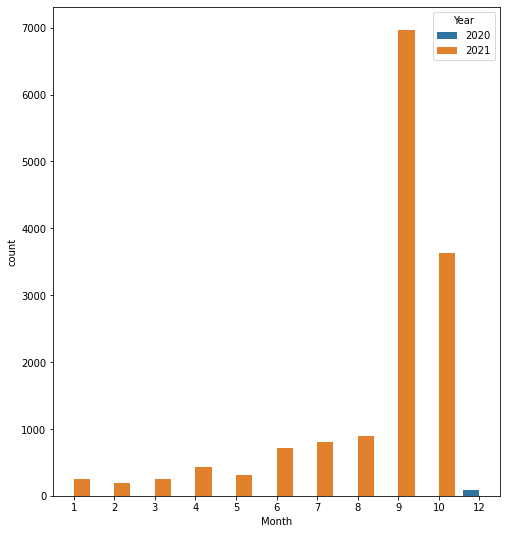

In [13]:
plt.figure(figsize=(8,9))
sns.countplot(data=df,x='Month',hue='Year')

Nel seguente grafico è riportata la distribuzione delle lunghezze dei vari commenti, la maggior parte dei commenti è inferiore a **20 caratteri** rosso, nel blu invece è riportata il numero di parole 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


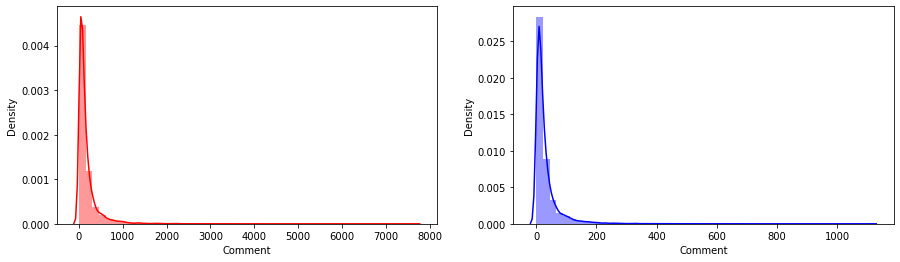

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(15,4))
fig.add_subplot(1,2,1)
sns.distplot((df['Comment'].apply(len)),color='red') # lunghezza del testo in caratteri


fig.add_subplot(1,2,2)
sns.distplot((df['Comment'].apply(lambda x: len(x.split()))),color='blue') # split -> numero di parole



# **Text preprocessing**

per ottenere un sentiment accurato è necessario effettuare un po di pulitura sul testo

In [10]:
stopwords = set(STOPWORDS)

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [15]:
df['Comment'] = df['Comment'].apply(lambda x: clean_text(x))
df['Comment'] = df['Comment'].apply(lambda x: remove_emoji(x))

In [16]:
# Print maximum number of words in a comment
df['Comment'].apply(lambda x:len(str(x).split())).max()

1087

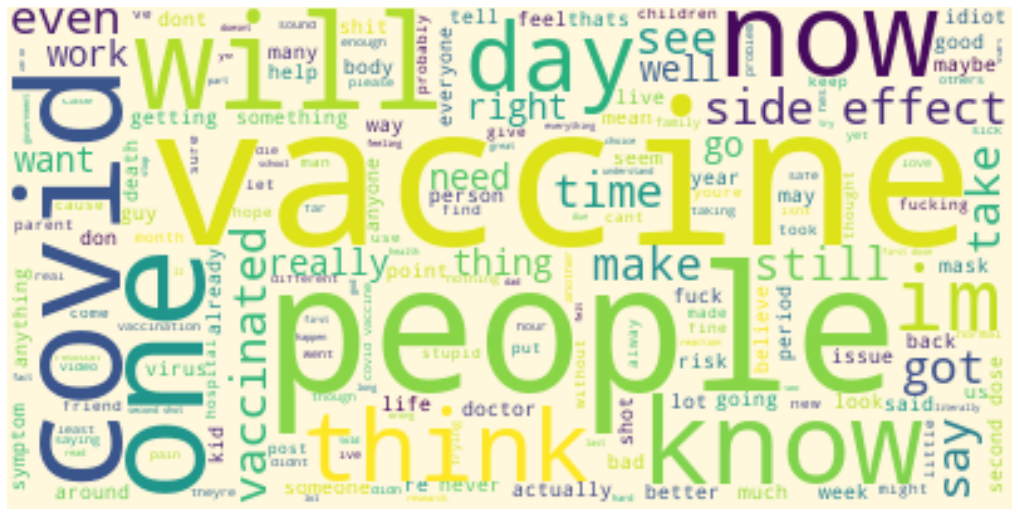

In [17]:
text=df["Comment"].to_csv()
comment_wc = WordCloud(
    background_color='cornsilk',
    max_words=1000,
    stopwords=stopwords
)
comment_wc.generate(text)
plt.figure(figsize=(18,18))
plt.imshow(comment_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Side effects, analisi della nuvola 






# **Sentiment analysis**


In [ ]:
# TODO
#!pip install spacy
#from spacy import SpacyTextBlob

In [74]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pprint as pp
sia = SIA()
results = []

for line in df.Comment:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

# result = [ {'compound': 0.0,
#   'headline': 'Please do not brigade other subreddits. This is very much against the Reddit Terms '
#               'and Conditions and it is strictly enforced by the Reddit admins. Please don’t do it '
#               'in the future or it will result in a ban.',
#   'neg': 0.083,
#   'neu': 0.81,
#   'pos': 0.106},

In [76]:
df_result = []
for c in results:
  # df_result.append([c['neg'],c['pos'],c['neu']])
  df_result.append([c['compound']])
df_result = pd.DataFrame(df_result)

In [78]:
df['SIA'] = df_result[0]

In [81]:
df = df.drop(columns=['pos','neg','neu'])

In [21]:
df['neg'] = df_result[0]
df['pos'] = df_result[1]
df['neu'] = df_result[2]

In [84]:
df['SIA2'] = df['SIA'] + 1*(10**(-6))

In [86]:
df['flair_score'] = df['flair_score'] +  1*(10**(-6))

In [87]:
res = pd.DataFrame()
res['compairing'] = df['flair_score'] * df['SIA2']
res.head()

,compairing
0,-9.998990e-07
1,-9.982990e-07
2,-6.156841e-01
3,7.717576e-02
4,5.085010e-07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14bfd84250>]],
      dtype=object)

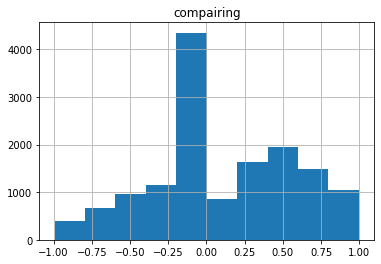

In [90]:
res.hist()

In [85]:
df.head()

,Author,Comment,Score,Year,Month,Day,flair_score,SIA,SIA2
0,Genos-Cyborg,please do not brigade other subreddits this is...,450,2020,10,29,-0.9999,0.0000,0.000001
1,NotAPie,man placing antimasker stickers around,838,2021,10,13,-0.9983,0.0000,0.000001
2,nzstrawman,i love the way the anti maskers and anti vaxxe...,227,2021,10,13,-0.6883,0.8945,0.894501
3,HellveticaNeue,this dude is probably years old and he’s beha...,249,2021,10,13,-0.9997,-0.0772,-0.077199
4,The_awful_falafel,how they think we respond to stickershow we ac...,70,2021,10,13,0.5085,0.0000,0.000001


In [ ]:
fig, axe = plt.subplots(1,3, figsize=(23,5))
sns.countplot(df['sentiment'], ax=axe[0])
sns.boxenplot(x=train['sentiment'], y=train['length'], data=train, ax=axe[1])
sns.boxenplot(x=train['sentiment'], y=train['word_n'], data=train, ax=axe[2])

In [ ]:
ax = plt.subplots(figsize=(8, 8))


sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [ ]:
!pip3 install flair
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [46]:
sentiment_score_flair("i don't love you")

ValueError: ignored

In [ ]:
flair_sentiment.label_dictionary.get_idx_for_items

<bound method Dictionary.get_idx_for_items of <flair.data.Dictionary object at 0x7fa6adbcbcd0>>

In [70]:
def sentiment_score_flair(sentence):
  if not isinstance(sentence, str):
    print("non stringa")
    return 0
  if sentence == "": 
    return 0
  sentence = clean_text(sentence)
  sentence = remove_emoji(sentence)
  s = flair.data.Sentence(sentence)
  flair_sentiment.predict(s)
  total_sentiment = s.labels
  #print(total_sentiment)
  if len(total_sentiment) <1:
    return 0
  if len(str(total_sentiment[0]).split()) != 2:
    return 0
  x = float(str(total_sentiment[0]).split()[1][1:-1])
  if str(total_sentiment[0]).split()[0][0:1] == 'P':
    sign = 1
  else:
    sign = -1
  return x * sign

In [71]:
from tqdm import tqdm
tqdm.pandas()
df['flair_score'] = df['Comment'].progress_apply(sentiment_score_flair)

100%|██████████| 14528/14528 [23:45<00:00, 10.19it/s]


In [ ]:
nltk.download('stopwords')

In [73]:
df.to_csv("drive/MyDrive/covid_vax_flair_SIA.csv")